In [1]:
!pip install kagglehub
!pip install joblib


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib



#**Download data set**



In [3]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
csv_file_path = os.path.join(path, 'heart.csv')

# Read into DataFrame
df = pd.read_csv(csv_file_path)
print("DataFrame columns:", df.columns.tolist())
df.head()


DataFrame columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#**Data preproccesing**

In [11]:
if 'HeartDisease' in df.columns:
    df.rename(columns={'HeartDisease': 'target'}, inplace=True)

# Encoding
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = pd.factorize(df[col])[0]

# Spliting
X = df.drop('target', axis=1)
y = df['target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



#**PCA**

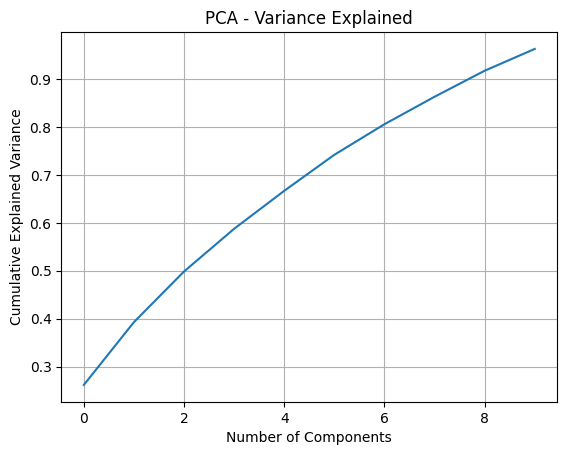

In [12]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Plot variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained')
plt.grid(True)
plt.show()

#**Feature selection**

In [5]:
model_rfe = RandomForestClassifier()
rfe = RFE(model_rfe, n_features_to_select=10)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)


#**train model**

In [13]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1]))




Logistic Regression:

              precision    recall  f1-score   support

           0       0.76      0.83      0.80        77
           1       0.87      0.81      0.84       107

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

AUC Score: 0.8859084840393252

Decision Tree:

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        77
           1       0.86      0.83      0.84       107

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

AUC Score: 0.8184852530646923

Random Forest:

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        77
           1       0.89      0.85      0.87       107

    accuracy                           0.85       184
   macro av

#**Evaluate the model**

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

Confusion Matrix:
 [[67 10]
 [17 90]]
AUC Score: 0.9237771574220174


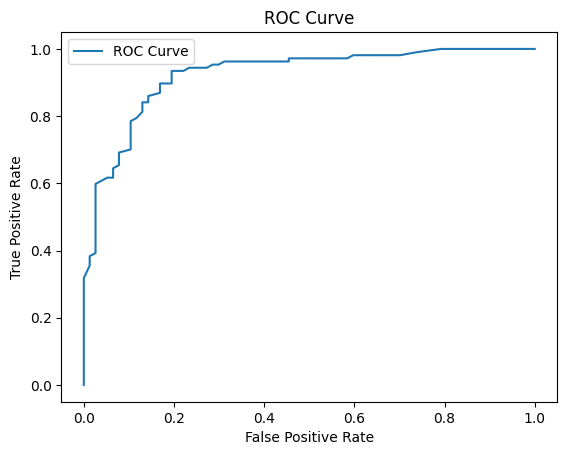

In [7]:
y_pred = model.predict(X_test_selected)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_selected)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


#**Hyper tunnig**

In [8]:
param_grid = {'n_estimators': [50, 100, 150]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train_selected, y_train)
print("Best Parameters:", grid.best_params_)


Best Parameters: {'n_estimators': 100}


#**Clustring Process**

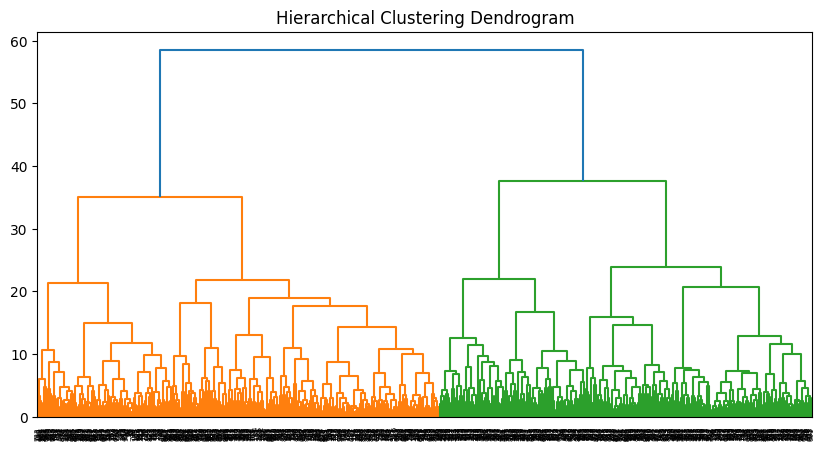

In [14]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(X_scaled)

# Hierarchical Dendrogram
linked = linkage(X_scaled, 'ward')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


#**Saving the model**

In [15]:
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(grid.best_estimator_, 'models/final_model.pkl')


['models/final_model.pkl']